torch.Size([100, 10])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 10])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 10])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 10])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 10])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 10])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([63, 10])
torch.Size([63, 1])
torch.Size([63, 1])
4364886.099609375
torch.Size([100, 10])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 10])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 10])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 10])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 10])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 10])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([63, 10])
torch.Size([63, 1])
torch.Size([63, 1])
283836.10546875
torch.Size([100, 10])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([

TypeError: unhashable type: 'dict'

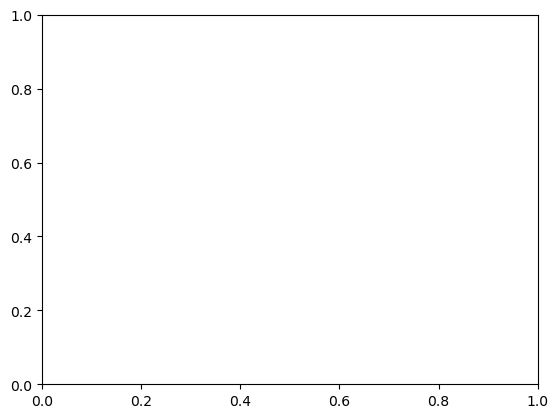

In [3]:
import pandas as pd
import numpy as np
import torch
import time
import os
import json
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import r2_score

class PriceNightDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values).float()
        self.y = torch.tensor(y.values).float().view(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

def generate_nn_configs(num_configs):
    """Generate a list of config dictionaries for the neural network.

    Parameters:
    num_configs (int): The number of config dictionaries to generate.

    Returns:
    list: A list of config dictionaries.
    """
    configs = []
    for _ in range(num_configs):
        config = {
            'learning_rate': random.uniform(0.0001, 0.001),
            'hidden_size': random.randint(1, 20)
        }
        configs.append(config)
    return configs

def train(X_train, y_train, config, train_loader):
    """Train a neural network model.

    Parameters:
    X_train (pandas DataFrame): The training input data.
    y_train (pandas Series): The training output data.
    config (dict): A dictionary containing the hyperparameters for the model.
    train_loader (torch DataLoader): A DataLoader for the training set.

    Returns:
    torch model: The trained model.
    """
    # Define the model
    model = torch.nn.Sequential(
        torch.nn.Linear(10, config['hidden_size']),  # 10 input features, hidden_size outputs
        torch.nn.ReLU(),
        torch.nn.Linear(config['hidden_size'], 1)  # hidden_size inputs, 1 output (prediction)
    )

    # Define the optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'])

    # Define the loss function
    loss_fn = torch.nn.MSELoss()
    since = time.time()
    # Train the model
    for i in range(100):
        # Initialize the loss for the epoch
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            # Make predictions and compute the loss
            y_pred = model(X_batch)
            print(X_batch.shape)
            print(y_pred.shape)
            print(y_batch.shape)
            loss = loss_fn(y_pred, y_batch)
            epoch_loss += loss.item()

            # Backpropagate the gradients and update the model parameters
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(epoch_loss)

    return model


def evaluate(model, X_test_tensor, y_test_tensor, test_loader):
    """Evaluate a model on the test set.

    Parameters:
    model (torch model): The model to evaluate.
    X_test (pandas DataFrame): The test input data.
    y_test (pandas Series): The test output data.
    test_loader (torch DataLoader): A DataLoader for the test set.

    Returns:
    tuple: A tuple containing the model's loss and R^2 value on the test set.
    """
    # Define the loss function
    loss_fn = torch.nn.MSELoss()
    
    # Initialize the loss and R^2 values for the test set
    test_loss = 0
    test_r2 = 0

    # Evaluate the model on the test set
    y_test_pred = model(X_test_tensor)
    test_loss = loss_fn(y_test_pred, y_test_tensor)

    # Calculate the R^2 value
    y_test_mean = y_test_tensor.mean()
    numerator = ((y_test_tensor - y_test_pred) ** 2).sum()
    denominator = ((y_test_tensor - y_test_mean) ** 2).sum()
    r2 = 1 - (numerator / denominator)

    return test_loss, r2


def save_model(model, save_dir, hyperparameters):
    """Save a model and its hyperparameters to the specified folder.

    Parameters:
    model (torch model): The model to save.
    save_dir (str): The directory to save the model in.
    hyperparameters (dict): A dictionary containing the model's hyperparameters.
    """
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Save the model
    torch.save(model.state_dict(), os.path.join(save_dir, 'model.pt'))

    # Save the hyperparameters
    with open(os.path.join(save_dir, 'hyperparameters.json'), 'w') as f:
        json.dump(hyperparameters, f)

def find_best_nn(X_train, y_train, X_test, y_test, num_configs, save_dir):
    """Find the best neural network by training a model for each config.

    Parameters:
    X_train (pandas DataFrame): The training input data.
    y_train (pandas Series): The training output data.
    X_test (pandas DataFrame): The test input data.
    y_test (pandas Series): The test output data.
    num_configs (int): The number of configs to generate and evaluate.
    save_dir (str): The directory to save the best model in.

    Returns:
    tuple: A tuple containing the best model, the metrics of the best model, and the hyperparameters of the best model.
    """
    # Generate configs
    configs = generate_nn_configs(num_configs)

    # Initialize the best model and its metrics and hyperparameters
    best_model = None
    best_metrics = {'loss': float('inf'), 'r2': -float('inf')}
    best_hyperparameters = None
    best_config = None

    # Convert the data to tensors
    X_train_tensor = torch.tensor(X_train.values).float()
    y_train_tensor = torch.tensor(y_train.values).float().view(-1, 1)  # reshape to be a 2D tensor
    X_test_tensor = torch.tensor(X_test.values).float()
    y_test_tensor = torch.tensor(y_test.values).float().view(-1, 1)  # reshape to be a 2D tensor

    # Create datasets for the training and test sets
    train_dataset = PriceNightDataset(X_train, y_train)
    test_dataset = PriceNightDataset(X_test, y_test)

    # Create DataLoaders for the training and test sets
    train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)  

    writer = SummaryWriter()

    # Train and evaluate models for each config
    for config in configs:
        # Train the model
        start_time = time.time()
        model = train(X_train, y_train, config, train_loader)

        # Evaluate the model on the test set
        test_loss, r2 = evaluate(model, X_test_tensor, y_test_tensor, test_loader)

        # Log the loss and R^2 values to TensorBoard
        writer.add_scalar('loss', test_loss, global_step=config['hidden_size'])
        writer.add_scalar('r2', r2, global_step=config['hidden_size'])

        # Get time taken and inference latency 
        end_time = time.time()
        latency = end_time - start_time

        # Save the model if it performs the best so far
        if test_loss < best_metrics['loss'] and r2 > best_metrics['r2']:
            best_model = model
            best_metrics = {'loss': test_loss, 'r2': r2}
            best_hyperparameters = config
            best_config=config
            additional_info = {'time_taken': latency,
                      'inference_latency': latency / len(X),  # inference latency per sample
                      'r_squared': r2.item()}
            print(best_hyperparameters)
            best_hyperparameters.update(additional_info)
            print(best_hyperparameters)
            save_model(best_model, save_dir, best_hyperparameters)
            print(best_hyperparameters)
            print(best_metrics)


    # Plot the loss and R^2 values
    test_loss=test_loss.detach().numpy()
    r2=r2.detach().numpy()
    plt.plot(config, test_loss, label='Loss')
    plt.plot(config, r2, label='R^2')

    writer.close()
    return best_model, best_metrics, best_config


# Read the CSV file and extract the 'Price_Night' column
df = pd.read_csv('tabular_data/tabular_data/clean_tabular_data.csv')
X = df[["guests","beds","bathrooms","Cleanliness_rating","Accuracy_rating","Communication_rating","Location_rating","Check-in_rating","Value_rating","amenities_count"]] # get all columns except the last one
y = df['Price_Night']  # get the 'Price_Night' column

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

num_configs = 16
save_dir = "C:/Users/dongc/Desktop/Code/python/AiCore/airbnb_model/models/neural_networks/"
find_best_nn(X_train, y_train, X_test, y_test, num_configs, save_dir)

